In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from seg_metrics import seg_metrics, initialize_metrics_dict

In [2]:
img = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_img.nii.gz"))
one = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_1_tgt.nii.gz"))
two = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_2_tgt.nii.gz"))
three = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_3_tgt.nii.gz"))
staple = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_STAPLE_tgt.nii.gz"))
pred = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_medpseg_output.nii.gz"))

def rgbfy(x, ggo_id=1, con_id=2):
    x = np.stack([np.zeros_like(x), x == ggo_id, x == con_id], axis=0).astype(np.float32)
    return x

In [3]:
def stats(x, tgt, label):
    ggo_vol = x[1].sum()
    con_vol = x[2].sum()
    inf_vol = ggo_vol + con_vol

    metrics = initialize_metrics_dict()
    
    x2d = x[1:].transpose(1, 0, 2, 3)
    tgt2d = tgt[1:].transpose(1, 0, 2, 3)
    
    for x_i, tgt_i in zip(x2d, tgt2d):
        seg_metrics(np.expand_dims(tgt_i, 1).astype(np.uint8), np.expand_dims(x_i, 1).astype(np.uint8), metrics, ["ggo", "con"])

    x_inf = np.expand_dims(tgt[1:].sum(axis=0), 1).astype(np.uint8)
    tgt_inf = np.expand_dims(x[1:].sum(axis=0), 1).astype(np.uint8)
    for x_inf_i, tgt_inf_i in zip(x_inf, tgt_inf):
        seg_metrics(np.expand_dims(tgt_inf_i, 1), np.expand_dims(x_inf_i, 1), metrics, ["inf"])

    stats = metrics.stats()
    volumes = {"GGO volume": ggo_vol, "Consolidation volume": con_vol, "Infection volume": inf_vol}
    stats.update(volumes)
    stats["metrics"] = metrics
    
    print(stats)
    print(f"{label} stats:")
    print(volumes)
    print(f"INF Dice: {round(stats['inf']['dice']['mean'], 3)}+-{round(stats['inf']['dice']['std'], 3)}")
    print(f"GGO Dice: {round(stats['ggo']['dice']['mean'], 3)}+-{round(stats['ggo']['dice']['std'], 3)}")
    print(f"Con Dice: {round(stats['con']['dice']['mean'], 3)}+-{round(stats['con']['dice']['std'], 3)}")

    return stats

C_stats = stats(rgbfy(one), rgbfy(staple), "One")
P_stats = stats(rgbfy(two), rgbfy(staple), "Two")
V_stats = stats(rgbfy(three), rgbfy(staple), "Three")
staple_stats = stats(rgbfy(staple), rgbfy(staple), "Staple")  # STAPLE VS ITSELF

OneTwo = stats(rgbfy(one), rgbfy(two), "1vs2")
OneThree = stats(rgbfy(one), rgbfy(three), "1vs3")
TwoThree = stats(rgbfy(two), rgbfy(three), "2vs3")


c:\Users\carmo\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


defaultdict(<function MetricDict.stats.<locals>.<lambda> at 0x0000019E794C3700>, {'ggo': defaultdict(<class 'dict'>, {'dice': {'mean': 0.7725102691263999, 'std': 0.1345839711158739}, 'false_negative_error': {'mean': 0.027780694450197423, 'std': 0.02210232980573384}, 'false_positive_error': {'mean': 0.34015986276683957, 'std': 0.16652987531137034}, 'jaccard': {'mean': 0.6469790440055913, 'std': 0.16148262332725316}, 'volume_similarity': {'mean': 0.4106365876952593, 'std': 0.2758574148708611}, 'abs_volume_similarity': {'mean': 0.7946817061523704, 'std': 0.13792870743543054}, 'avg_hd': {'mean': 2.487578696614682, 'std': 3.640716249276784}, 'hd': {'mean': 52.65367452313284, 'std': 39.074593952404975}, 'sensitivity': {'mean': 0.9722193055498025, 'std': 0.022102329805733838}, 'specificity': {'mean': 0.9778836904438771, 'std': 0.010841511035189261}, 'precision': {'mean': 0.6598401372331604, 'std': 0.16652987531137034}}), 'con': defaultdict(<class 'dict'>, {'dice': {'mean': 0.6994010375553777,

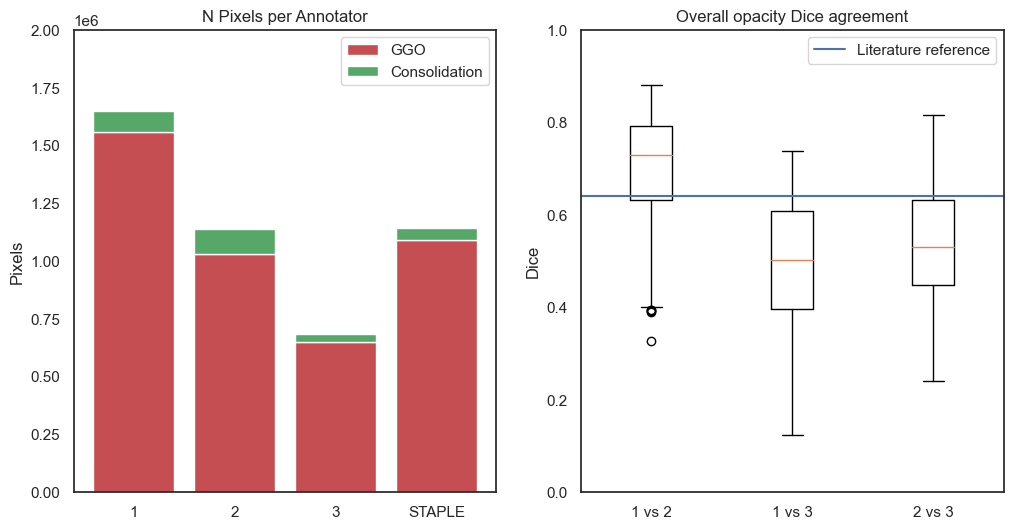

In [6]:
import seaborn as sns
sns.set_theme(style="white")
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bottom = np.zeros(4)

x = [0, 1, 2, 3]
width = 0.8

ys = np.array([C_stats["GGO volume"], P_stats["GGO volume"], V_stats["GGO volume"], staple_stats["GGO volume"]])
ax1.bar(x, ys, width=width, label="GGO", color='r')
bottom += ys

ys2 = np.array([C_stats["Consolidation volume"], P_stats["Consolidation volume"], V_stats["Consolidation volume"], staple_stats["Consolidation volume"]])
ax1.bar(x, ys2, width=width, bottom=bottom, label="Consolidation", color='g')
bottom += ys2

ax1.set_ylabel("Pixels")
ax1.set_xticks(x)
ax1.set_xticklabels(['1', '2', '3', "STAPLE"])
ax1.set_ylim(0, 2e6)
ax1.set_title("N Pixels per Annotator")
ax1.legend()


ax2.boxplot([OneTwo["metrics"]["inf"]["dice"], OneThree["metrics"]["inf"]["dice"], TwoThree["metrics"]["inf"]["dice"]])
ax2.axhline(0.64, label="Literature reference")
ax2.legend()
ax2.set_ylabel("Dice")
ax2.set_title("Overall opacity Dice agreement")
ax2.set_ylim(0, 1.0)
ax2.set_xticklabels(['1 vs 2', '1 vs 3', '2 vs 3'])


plt.show()

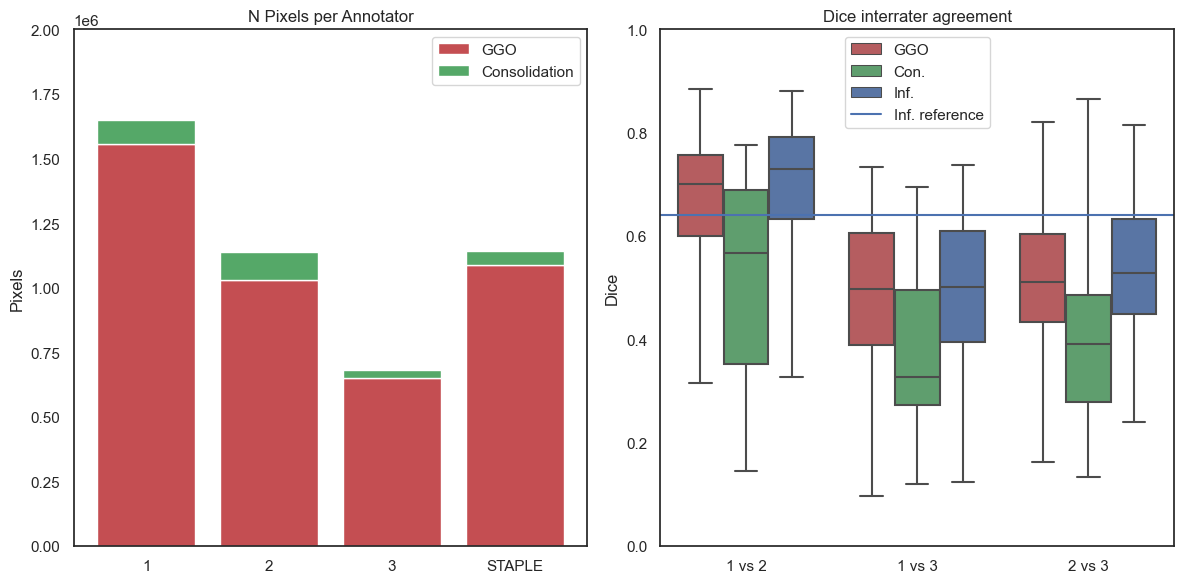

In [25]:
import seaborn as sns
from collections import defaultdict
sns.set_theme(style="white")

map_target_str = {"ggo": "GGO",
                  "con": "Con.",
                  "inf": "Inf."}

final_df = defaultdict(list)
for comparison, df in [("1 vs 2", OneTwo), ("1 vs 3", OneThree), ("2 vs 3", TwoThree)]:
    for target in ["ggo", "con", "inf"]:
        vs = df["metrics"][target]["dice"]
        if target == "con":
            # Include only cases where both annotators annotate in this slice for con
            vs = [v for v in vs if v not in [0.0, 1.0]]
        final_df["Dice"] += vs
        final_df["Target"]+= [map_target_str[target]]*len(vs)
        final_df["Comparison"] += [comparison]*len(vs)
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar
bottom = np.zeros(4)

x = [0, 1, 2, 3]
width = 0.8

ys = np.array([C_stats["GGO volume"], P_stats["GGO volume"], V_stats["GGO volume"], staple_stats["GGO volume"]])
ax1.bar(x, ys, width=width, label="GGO", color='r')
bottom += ys

ys2 = np.array([C_stats["Consolidation volume"], P_stats["Consolidation volume"], V_stats["Consolidation volume"], staple_stats["Consolidation volume"]])
ax1.bar(x, ys2, width=width, bottom=bottom, label="Consolidation", color='g')
bottom += ys2

ax1.set_ylabel("Pixels")
ax1.set_xticks(x)
ax1.set_xticklabels(['1', '2', '3', "STAPLE"])
ax1.set_ylim(0, 2e6)
ax1.set_title("N Pixels per Annotator")
ax1.legend()

# Boxplot
sns.boxplot(x="Comparison", y="Dice", hue="Target", palette=["r", "g", "b"], data=final_df, ax=ax2, whis=2)
ax2.axhline(0.64, label="Inf. reference")
ax2.set_title("Dice interrater agreement")
ax2.set_ylabel("Dice")
ax2.set_ylim(0.0, 1.0)
ax2.legend()
plt.tight_layout()
plt.savefig("bar_boxplot.pdf", dpi=300)
plt.show()